In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn import metrics
from sklearn import linear_model
import gc
import warnings
import time
warnings.filterwarnings("ignore")
import pickle
import sys

In [2]:
def fast_auc(y_true, y_prob):
    """
    fast roc_auc computation: https://www.kaggle.com/c/microsoft-malware-oofiction/discussion/76013
    """
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    nfalse = 0
    auc = 0
    n = len(y_true)
    for i in range(n):
        y_i = y_true[i]
        nfalse += (1 - y_i)
        auc += y_i * nfalse
    auc /= (nfalse * (n - nfalse))
    return auc
def eval_auc(y_true, y_oof):
    """
    Fast auc eval function for lgb.
    """
    return 'auc', fast_auc(y_true, y_oof), True
def group_mean_log_mae(y_true, y_oof, types, floor=1e-9):
    """
    Fast metric computation for this competition: https://www.kaggle.com/c/champs-scalar-coupling
    Code is from this kernel: https://www.kaggle.com/uberkinder/efficient-metric
    """
    maes = (y_true - y_oof).abs().groupby(types).mean()
    return np.log(maes.map(lambda x: max(x, floor))).mean()
def plot_importance(result_dict, file=None):
    feature_importance = result_dict['feature_importance']
    cols = result_dict['top_columns']
    best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

    plt.figure(figsize=(16, 12))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LGB Features (avg over folds)')
    if file is not None:
        plt.savefig(file)
def train_model_classification(X, X_test, y, params, folds, model_type='lgb', eval_metric='auc', columns=None,
                               plot_feature_importance=False, model=None,
                               verbose=10000, early_stopping_rounds=200, n_estimators=50000, splits=None,
                               averaging='usual', n_jobs=-1, groups=None):
    """
    A function to train a variety of classification models.
    Returns dictionary with oof oofictions, test oofictions, scores and, if necessary, feature importances.
    :params: X - training data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: X_test - test data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: y - target
    :params: folds - folds to split data
    :params: model_type - type of model to use
    :params: eval_metric - metric to use
    :params: columns - columns to use. If None - use all columns
    :params: plot_feature_importance - whether to   plot feature importance of LGB
    :params: model - sklearn model, works only for "sklearn" model type
    """
    columns = X.columns if columns is None else columns
    n_splits = folds.n_splits if splits is None else splits
    if X_test is not None:
        X_test = X_test[columns]

    # to set up scoring parameters
    metrics_dict = {'auc': {'lgb_metric_name': eval_auc,
                            'catboost_metric_name': 'AUC',
                            'sklearn_scoring_function': metrics.roc_auc_score},
                    }

    result_dict = {}
    if averaging == 'usual':
        # out-of-fold oofictions on train data
        oof = np.zeros((len(X), 1))

        # averaged oofictions on train data
        if X_test is not None:
            oofiction = np.zeros((len(X_test), 1))

    elif averaging == 'rank':
        # out-of-fold oofictions on train data
        oof = np.zeros((len(X), 1))

        # averaged oofictions on train data
        if X_test is not None:
            oofiction = np.zeros((len(X_test), 1))

    # list of scores on folds
    scores = []
    feature_importance = pd.DataFrame()

    # split and train on folds
    if groups is None:
        splitter = folds.split(X, y)
    else:
        splitter = folds.split(X, y, groups=groups)
    for fold_n, (train_index, valid_index) in enumerate(splitter):
        gc.collect()
        if fold_n < folds.n_splits - n_splits:
            continue
        print(f'Fold {fold_n + 1} started at {time.ctime()}')
        
        if type(X) == np.ndarray:
            X_train, X_valid = X[columns][train_index], X[columns][valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else:
            X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

        if model_type == 'lgb':
            model = lgb.LGBMClassifier(**params, n_estimators=n_estimators, n_jobs=n_jobs)
            model.fit(X_train, y_train,
                      eval_set=[(X_train, y_train), (X_valid, y_valid)],
                      eval_metric=metrics_dict[eval_metric]['lgb_metric_name'],
                      verbose=verbose, early_stopping_rounds=early_stopping_rounds)

            y_oof_valid = model.oofict_proba(X_valid)[:, 1]
            if X_test is not None:
                y_oof = model.oofict_proba(X_test, num_iteration=model.best_iteration_)[:, 1]

        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=n_estimators, evals=watchlist,
                              early_stopping_rounds=early_stopping_rounds, verbose_eval=verbose, params=params)
            y_oof_valid = model.oofict(xgb.DMatrix(X_valid, feature_names=X.columns),
                                         ntree_limit=model.best_ntree_limit)
            if X_test is not None:
                y_oof = model.oofict(xgb.DMatrix(X_test, feature_names=X.columns), ntree_limit=model.best_ntree_limit)

        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)

            y_oof_valid = model.oofict_proba(X_valid)[:, 1].reshape(-1, )
            score = metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_oof_valid)
            print(f'Fold {fold_n}. {eval_metric}: {score:.4f}.')
            print('')
            if X_test is not None:
                y_oof = model.oofict_proba(X_test)[:, 1]

        if model_type == 'keras':
            kmodel: Model = model()
            kmodel.fit(X_train, y_train, validation_data=(X_valid, y_valid), **params)
            oofict_params = {k: v for k, v in params.items() if k in ['batch_size', 'verbose', 'steps', 'callbacks',
                                                                       'max_queue_size', 'workers',
                                                                       'use_multiprocessing']}
            y_oof_valid = kmodel.oofict(X_valid, **oofict_params)
            score = metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_oof_valid)
            print(f'Fold {fold_n}. {eval_metric}: {score:.4f}.')
            if X_test is not None:
                y_oof = kmodel.oofict(X_test)

        if model_type == 'cat':
            model = CatBoostClassifier(iterations=n_estimators,
                                       eval_metric=metrics_dict[eval_metric]['catboost_metric_name'], **params,
                                       loss_function=metrics_dict[eval_metric]['catboost_metric_name'])
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True,
                      verbose=False)

            y_oof_valid = model.oofict_proba(X_valid)[:,1]
            if X_test is not None:
                y_oof = model.oofict_proba(X_test)[:,1]

        if averaging == 'usual':

            oof[valid_index] = y_oof_valid.reshape(-1, 1)
            scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_oof_valid))
            if X_test is not None:
                oofiction += y_oof.reshape(-1, 1)

        elif averaging == 'rank':

            oof[valid_index] = y_oof_valid.reshape(-1, 1)
            scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_oof_valid))
            if X_test is not None:
                oofiction += pd.Series(y_oof).rank().values.reshape(-1, 1)

        if model_type == 'lgb' and plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    if X_test is not None:
        oofiction /= n_splits

    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))

    result_dict['oof'] = oof
    if X_test is not None:
        result_dict['oofiction'] = oofiction
    result_dict['scores'] = scores

    if model_type == 'lgb':
        if plot_feature_importance:
            feature_importance["importance"] /= n_splits
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            result_dict['feature_importance'] = feature_importance
            result_dict['top_columns'] = cols
            plot_importance(result_dict)

    return result_dict

# Blend it

In [21]:
s1 = pd.read_csv(r'C:\Users\zimin\kaggle\Blending\prediction_all_data_best_lgb_26.csv') #94.59
s2 = pd.read_csv(r'C:\Users\zimin\kaggle\Blending\prediction_all_data_best_lgb_timefreq.csv')   #95.04
s3 = pd.read_csv(r'C:\Users\zimin\kaggle\Blending\prediction_all_data_best_lgb.csv')  #94.84
s4 = pd.read_csv(r'C:\Users\zimin\kaggle\Blending\lgb_pca.csv')   #94.98
s5 = pd.read_csv(r'C:\Users\zimin\kaggle\Blending\lgb_new_card_id_del_mean020_v3.csv') #94.70

s6 = pd.read_csv(r'C:\Users\zimin\kaggle\Blending\9517.csv') #95.17
s7 = pd.read_csv(r'C:\Users\zimin\kaggle\Blending\9501.csv') #95.01
s8 = pd.read_csv(r'C:\Users\zimin\kaggle\Blending\9480.csv') #94.80
s9 = pd.read_csv(r'C:\Users\zimin\kaggle\Blending\9522.csv') #95.22

s10 = pd.read_csv(r'C:\Users\zimin\kaggle\Blending\submission_dynamic_cat_final_6folds_20.csv') #95.14
s11 = pd.read_csv(r'C:\Users\zimin\kaggle\Blending\prediction_catboost_last.csv') #95.11

s12 = pd.read_csv(r'C:\Users\zimin\kaggle\Blending\prediction-catboost-work.csv') #95.12
s13 = pd.read_csv(r'C:\Users\zimin\kaggle\Blending\prediction_lightgbm-work-2.csv') #94.76

s14 = pd.read_csv(r'C:\Users\zimin\kaggle\Blending\ieee_nn.csv') #92.27
s15 = pd.read_csv(r'C:\Users\zimin\kaggle\Blending\submission_dynamic_cat_work_6folds_20.csv') # 95.12

In [34]:
bl = pd.read_csv(r'C:\Users\zimin\kaggle\Blending\sub.csv').set_index('TransactionID')

In [ ]:
# 11 и 15 маленькие

# best of the best of the best

In [17]:
sub = pd.DataFrame(index = s1['TransactionID'], columns=['isFraud'])

sub['isFraud'] = (s1.set_index('TransactionID')['isFraud']*0.06 + 
              s2.set_index('TransactionID')['isFraud']*0.4 + 
              s5.set_index('TransactionID')['isFraud']*0.1 + 
#               s6.set_index('TransactionID')['isFraud']*0.5 + 
              s8.set_index('TransactionID')['isFraud']*0.2 +
              s9.set_index('TransactionID')['isFraud']*0.6 +
              s10.set_index('TransactionID')['isFraud']*0.7 +
              s11.set_index('TransactionID')['isFraud']*0.8 
                 )

sub

,isFraud
TransactionID,
3663549,0.002055
3663550,0.002651
3663551,0.003805
3663552,0.004296
3663553,0.011939
3663554,0.005600
3663555,0.019861
3663556,0.052745
3663557,0.001476


# try again

In [64]:
sub = pd.DataFrame(index = s1['TransactionID'], columns=['isFraud'])

sub['isFraud'] = (
    s1.set_index('TransactionID')['isFraud'].rank()*0.5 + 
              s2.set_index('TransactionID')['isFraud'].rank()*1 + 
              s3.set_index('TransactionID')['isFraud'].rank()*0.5 + 
              s4.set_index('TransactionID')['isFraud'].rank()*0.5 + 
              s5.set_index('TransactionID')['isFraud'].rank()*0.5 + 
              s6.set_index('TransactionID')['isFraud'].rank()*1 + 
              s7.set_index('TransactionID')['isFraud'].rank()*1 + 
              s8.set_index('TransactionID')['isFraud'].rank()*0.5 +
    
              s9.set_index('TransactionID')['isFraud'].rank()*1 +
              s10.set_index('TransactionID')['isFraud'].rank()*1 +
              s11.set_index('TransactionID')['isFraud'].rank()*1 +
                  
                  
              s12.set_index('TransactionID')['isFraud'].rank()*1 + 
              s13.set_index('TransactionID')['isFraud'].rank()*0.5 + 
              s14.set_index('TransactionID')['isFraud'].rank()*0.4 +
              s15.set_index('TransactionID')['isFraud'].rank()*1 
#               bl['isFraud']*1
                 )
# 11 и 15 маленькие
sub

,isFraud
TransactionID,
3663549,734244.40
3663550,1118427.10
3663551,1436399.40
3663552,1518411.10
3663553,2784574.40
3663554,1643136.00
3663555,3775340.90
3663556,4635621.50
3663557,399032.90


In [65]:
sub.to_csv('rankblend2.csv')

In [49]:
ss = [s1, s2, s3, s4, s5, s6, s7, s8, s9, s10, s11, s12, s13, s14, s15]

In [50]:
m_gmean1 = 0

for item in ss:
    m_gmean1 += np.log(item.set_index('TransactionID')['isFraud'])
    
m_gmean1 = np.exp(m_gmean1/len(ss))

In [51]:
m_gmean1 = pd.DataFrame(m_gmean1, columns=['isFraud'])
m_gmean1

,isFraud
TransactionID,
3663549,0.000691
3663550,0.001010
3663551,0.001115
3663552,0.001355
3663553,0.002747
3663554,0.001526
3663555,0.006338
3663556,0.014196
3663557,0.000414


In [52]:
m_gmean1.to_csv('once_again5_gmean.csv')

# Corrs

In [38]:
s = s1.join(s2, rsuffix='2').join(s3, rsuffix='3').join(s4, rsuffix='4').join(s5, rsuffix='5').join(s6, rsuffix='6').join(s7, rsuffix='7').join(s8, rsuffix='8').join(s9, rsuffix='9').join(s10, rsuffix='10').join(s11, rsuffix='11').join(s12, rsuffix='12').join(s13, rsuffix='13').join(s14, rsuffix='14').join(s15, rsuffix='15')
s = s.drop(['TransactionID10', 'TransactionID14','TransactionID2','TransactionID3','TransactionID4', 'TransactionID5', 'TransactionID6', 'TransactionID7','TransactionID8', 'TransactionID9', 'TransactionID11', 'TransactionID12', 'TransactionID13', 'TransactionID15'], axis=1).set_index('TransactionID')
s = s.join(bl, rsuffix='bl')

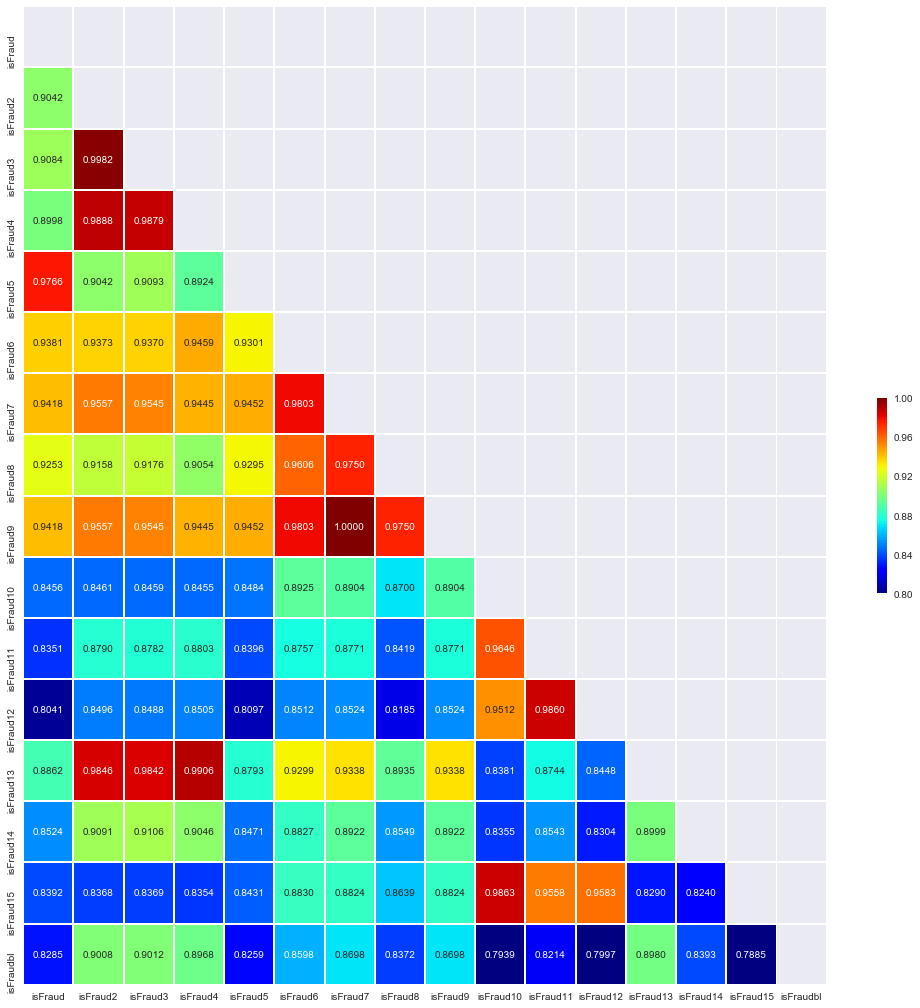

In [39]:
concat_sub = s.copy()
cols = list( range(len(s.columns)))


from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
corr = concat_sub.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(len(cols)+2, len(cols)+2))

# Draw the heatmap with the mask and correct aspect ratio
_ = sns.heatmap(corr,mask=mask,cmap='jet',linewidths=1,vmin=0.8, vmax=1,
                annot=True,fmt='.4f', cbar_kws={"shrink":.2})

In [ ]:
10 12 13 14 15

In [ ]:
исключаем 10, 11, 12, 13

# Stack it

In [146]:
oof1 = pd.read_csv(r'C:\Users\zimin\kaggle\Blending\oof_all_data_best_lgb_26.csv') #94.59
pred1 = pd.read_csv(r'C:\Users\zimin\kaggle\Blending\prediction_all_data_best_lgb_26.csv') #94.59

oof2 = pd.read_csv(r'C:\Users\zimin\kaggle\Blending\oof_all_data_best_lgb_timefreq.csv')   #95.04
pred2 = pd.read_csv(r'C:\Users\zimin\kaggle\Blending\prediction_all_data_best_lgb_timefreq.csv')   #95.04

pred3 = pd.read_csv(r'C:\Users\zimin\kaggle\Blending\oof_all_data_best_lgb.csv')  #94.84
oof3 = pd.read_csv(r'C:\Users\zimin\kaggle\Blending\oof_all_data_best_lgb.csv')  #94.84

pred4 = pd.read_csv(r'C:\Users\zimin\kaggle\Blending\lgb_pca.csv')   #94.98
oof4 = pd.read_csv(r'C:\Users\zimin\kaggle\Blending\oof_result_pca.csv')   #94.98

oof5 = pd.read_csv(r'C:\Users\zimin\kaggle\Blending\oof_lgb_new_card_id_del_mean020_v3.csv') #94.70
pred5 = pd.read_csv(r'C:\Users\zimin\kaggle\Blending\lgb_new_card_id_del_mean020_v3.csv') #94.70


In [149]:
oof = oof2.join(oof3, rsuffix='3').join(oof4, rsuffix='4')
oof.drop(['TransactionID3','TransactionID4'], axis=1, inplace=True)
oof.set_index('TransactionID', inplace=True)

In [150]:
pred = pred2.join(pred3, rsuffix='3').join(pred4, rsuffix='4')
pred.drop(['TransactionID3','TransactionID4'], axis=1, inplace=True)
pred.set_index('TransactionID', inplace=True)

In [136]:
y = pd.read_csv(r'C:\Users\zimin\kaggle\fraud\train_transaction.csv') 
y = y.set_index('TransactionID')[['isFraud']]

In [153]:
n_fold = 5
folds = KFold(n_splits=n_fold)

In [158]:
params = {
    'learning_rate': 0.01,
    'num_leaves': 20,
    'max_depth': 1,
    'min_child_weight': 10,
    'lambda_l1':2,
    'lambda_l2':3,
    'min_data_in_leaf' :10,
    'min_sum_hessian_in_leaf' : 0.0001,
    'bagging_fraction' : 0.8,
    'max_bin': 12,
    'feature_fraction' : 0.9,
    'bagging_freq' : 100,
    'min_gain_to_split': 0.1 }

train_options = {
    "model_type":'lgb',
    "params": params,
    "eval_metric":'auc',
    'early_stopping_rounds': 500,
    'n_estimators': 5000,
    'averaging': 'usual',
    'use_groups': False,
    'fold_name': folds.__class__.__name__,
    'n_splits': n_fold
}

Fold 1 started at Sun Sep 29 23:31:55 2019
Training until validation scores don't improve for 500 rounds.
[100]	training's binary_logloss: 0.104212	training's auc: 0.915739	valid_1's binary_logloss: 0.0862926	valid_1's auc: 0.891848
[200]	training's binary_logloss: 0.0963846	training's auc: 0.930009	valid_1's binary_logloss: 0.0844131	valid_1's auc: 0.900996
[300]	training's binary_logloss: 0.0940758	training's auc: 0.933155	valid_1's binary_logloss: 0.0843912	valid_1's auc: 0.903247
[400]	training's binary_logloss: 0.0932723	training's auc: 0.933579	valid_1's binary_logloss: 0.0845622	valid_1's auc: 0.90435
[500]	training's binary_logloss: 0.092947	training's auc: 0.93391	valid_1's binary_logloss: 0.0847848	valid_1's auc: 0.904319
[600]	training's binary_logloss: 0.0928037	training's auc: 0.933845	valid_1's binary_logloss: 0.0850848	valid_1's auc: 0.906857
[700]	training's binary_logloss: 0.0927463	training's auc: 0.933686	valid_1's binary_logloss: 0.0851658	valid_1's auc: 0.906971
Ea

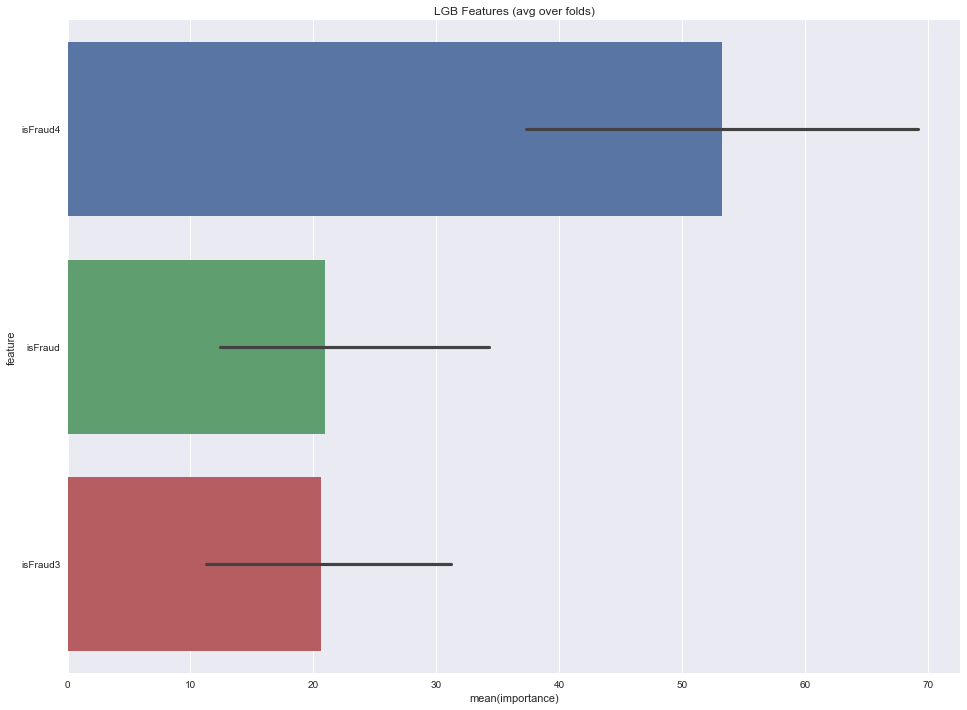

In [159]:
result_dict_lgb = train_model_classification(X=oof, X_test=pred, y=y, params=params, folds=folds,
                                         model_type=train_options['model_type'], 
                                         eval_metric=train_options['eval_metric'],
                                         plot_feature_importance=True,
                                         verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                         n_estimators=train_options['n_estimators'], 
                                         averaging=train_options['averaging'],
                                         n_jobs=-1, groups=None)

In [162]:
pd.DataFrame(result_dict_lgb['oof'], columns=['isFraud'], index=oof.index).to_csv('oof_stack_lgb.csv')
pd.DataFrame(result_dict_lgb['prediction'], columns=['isFraud'], index=pred.index).to_csv('prediction_stack_lgb.csv')
pd.DataFrame(result_dict_lgb['scores'], columns=['cv']).to_csv('scores_stack_lgb.csv')

sample_submission = pd.read_csv(r'C:\Users\zimin\kaggle\fraud\sample_submission.csv').set_index('TransactionID')

sub1 = pd.DataFrame(result_dict_lgb['prediction'], columns=['isFraud'], index=pred.index)

sample_submission['isFraud'] = sub1#*0.5 + sub2*0.25 + sub3*0.25

sample_submission.to_csv('stack_lgb.csv')